# 1 - Imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import jaxquantum.codes as jqtb
from jax import jit, grad, vmap
import jax.numpy as jnp
import numpy as np
from math import prod
import matplotlib.pyplot as plt

from tqdm import tqdm

import jax
import optax
import functools
import datetime

# 2 - Settings

In [3]:
settings = {
    "measure": None,
    "blocks": 7,
    "batch_size": 500,
    "epochs": 1000,
    "learning_rate": 5e-3,
    "N": 75,
    "state": {
        "mode": "gkp",
        "delta": 0.43846154,
        "logical_state": "-x"
    },
    "N_large": 200,
    "bounds": {
        "lower": [-1,-1,-4,-4],
        "upper": [1,1,4,4]
    },
    "random_seed": 41,
    "reg_strength": 5e-1,
    "reg_mode": 'avg',
    "minimize_metric": True
}


if settings["state"]["mode"] == "gkp":
    delta = settings["state"]["delta"]
    gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": settings["N"]})
    squeezing_level = 20*jnp.log10(jnp.exp(jnp.abs(jnp.log(delta))))
    settings["state"]["squeezing_level"] = squeezing_level
    target_state_cavity = gkp_qubit.basis[settings["state"]["logical_state"]]
    title = f"GKP Squeezing level: {squeezing_level:.2f} dB"


settings["target_state_cavity"] = target_state_cavity
settings["target_state"] = jqt.basis(2,0) ^ target_state_cavity

date_str = datetime.datetime.now().strftime("%Y%m%d_h%Hm%Ms%S")
settings["data_filename"] = f"data/{date_str}_{settings['state']['mode']}_state_prep.npz"

E0703 18:39:21.418452 1232863 ptx_compiler_helpers.cc:88] *** WARNING *** Invoking ptxas with version 12.4.99, which corresponds to a CUDA version <=12.6.2. CUDA versions 12.x.y up to and including 12.6.2 miscompile certain edge cases around clamping.
Please upgrade to CUDA 12.6.3 or newer.


'data/20250703_h18m39s25_gkp_state_prep.npz'

# 3 - Helpers

In [4]:
def run_circuit(params, N, measure=settings["measure"]):
    gammas_x = 2*jnp.pi*params[0]
    gammas_y = 2*jnp.pi*params[1]
    betas_re = params[2]
    betas_im = params[3]

    betas = betas_re + 1j*betas_im
    
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    for i in range(len(gammas_x)):
        cirq.append(jqtc.Rx(gammas_x[i]), 0)
        cirq.append(jqtc.Ry(gammas_y[i]), 0)
        cirq.append(jqtc.CD(N, betas[i]), [0, 1])
        cirq.append(jqtc.Rx(jnp.pi), 0)
    
    if measure == 'x':
        cirq.append(jqtc.MX_plus(), 0, default_simulate_mode="kraus")
        cirq.append(jqtc.Ry(-jnp.pi/2), 0)
        initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
        res = jqtc.simulate(cirq, initial_state, mode="default")
        return res[-1][-1]/res[-1][-1].trace()
        
    if measure == 'z':
        cirq.append(jqtc.MZ_plus(), 0, default_simulate_mode="kraus")
        initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
        res = jqtc.simulate(cirq, initial_state, mode="default")
        return res[-1][-1]/res[-1][-1].trace()
        

    initial_state = jqt.basis(2,0) ^ jqt.basis(N,0)
    res = jqtc.simulate(cirq, initial_state, mode="default")

    return res[-1][-1].unit()
    

def fid_metric(params, target_state):
    N = target_state.dims[0][1]
    prepared_state = run_circuit(params, N)
    return jnp.real(jqt.overlap(target_state, prepared_state))

fid_metric_vmap = jax.vmap(fid_metric, in_axes=(0, None))


def regularize(params, mode='avg'):
    betas_re = params[2]
    betas_im = params[3]

    betas_amp = jnp.abs(betas_re + 1j*betas_im)

    if mode=='avg':
        reg_loss = settings["reg_strength"] * jnp.average(betas_amp**2)
    if mode=='max':
        reg_loss = settings["reg_strength"] * jnp.max(betas_amp)**2
        
    return reg_loss

regularize_vmap = jax.vmap(regularize, in_axes=(0, None))


def metric(params, target_state):
    fids = fid_metric_vmap(params, target_state)
    losses = jnp.log10(1 - fids)
    #losses = 1.-fids
    avg_loss = losses
    reg_loss = regularize_vmap(params, settings['reg_mode'])
    
    return jnp.average(avg_loss + reg_loss)

def metric_non_avg(params, target_state):
    fids = fid_metric_vmap(params, target_state)
    losses = jnp.log10(1 - fids)
    #losses = 1.-fids
    avg_loss = losses
    reg_loss = regularize_vmap(params, settings['reg_mode'])

    return avg_loss + reg_loss

    


def cf_tomography_circuit(state, beta, measure_real=True):
    N = state.dims[0][1]
    reg = jqtc.Register([2,N])
    cirq = jqtc.Circuit.create(reg, layers=[])

    cirq.append(jqtc.Ry(jnp.pi/2), 0)
    cirq.append(jqtc.CD(N, beta), [0,1])
    
    if measure_real:
        cirq.append(jqtc.Ry(jnp.pi/2), 0)
    else:
        cirq.append(jqtc.Rx(jnp.pi/2), 0)

    res = jqtc.simulate(cirq, state)
    final_state = res[-1][-1]
    sigmaz = jqt.sigmaz() ^ jqt.identity(N)
    sigmaz_exp = final_state.dag() @ sigmaz @ final_state
    return sigmaz_exp.data[0][0].real

def sim_cf(osc_state, betas_re=None, betas_im=None):
    if len(osc_state.dims[0]) == 1:
        if osc_state.is_dm():
            state = jqt.ket2dm(jqt.basis(2,0)) ^ osc_state
        else:
            state = jqt.basis(2,0) ^ osc_state
    else:
        state = osc_state

    # Plot CF
    betas_re = betas_re if betas_re is not None else jnp.linspace(-4,4, 101)
    betas_im = betas_re if betas_re is not None else  jnp.linspace(-4,4, 101)
    betas = betas_re.reshape(-1,1) + 1j*betas_im.reshape(1,-1)
    betas_flat = betas.flatten()

    cf_tomography_circuit_vmap = jit(vmap(lambda beta: cf_tomography_circuit(state, beta, measure_real=True)))
    tomo_res_real = cf_tomography_circuit_vmap(betas_flat)

    cf_tomography_circuit_vmap = jit(vmap(lambda beta: cf_tomography_circuit(state, beta, measure_real=False)))
    tomo_res_imag = cf_tomography_circuit_vmap(betas_flat)
    
    tomo_res_real = tomo_res_real.reshape(*betas.shape)
    tomo_res_imag = tomo_res_imag.reshape(*betas.shape)

    tomo_res = tomo_res_real + 1j*tomo_res_imag

    return tomo_res, betas_re, betas_im


def calculate_cf(osc_state, betas_re=None, betas_im=None):
    # Plot CF
    N = osc_state.dims[0][0]

    betas_re = betas_re if betas_re is not None else jnp.linspace(-4,4, 41)
    betas_im = betas_im if betas_im is not None else jnp.linspace(-4,4, 41)
    betas = betas_re.reshape(-1,1) + 1j*betas_im.reshape(1,-1)
    
    cf_vals = np.zeros((len(betas_re), len(betas_im)), dtype=jnp.complex64)
    for j in tqdm(range(len(betas_re))):
        for k in range(len(betas_im)):
            cf_vals[j,k] = jqt.overlap(jqt.displace(N, betas[j,k]), osc_state)
    return cf_vals, betas_re, betas_im


# 4 - Batch Gradient Descent

In [7]:
# Option 2: random initialization

# Parameters
key = jax.random.PRNGKey(settings["random_seed"])  # Initialize a random key
B = settings["batch_size"] # Batch size
num_blocks = settings["blocks"]
lower_bounds = jnp.array(settings["bounds"]["lower"])  # Define the lower bounds for each axis
upper_bounds = jnp.array(settings["bounds"]["upper"])    # Define the upper bounds for each axis
random_initial_params = jax.random.uniform(
    key, shape=(B, 4, num_blocks), minval=lower_bounds[:, None], maxval=upper_bounds[:, None]
)

In [8]:
# Functions
metric_val_and_grad = jit(jax.value_and_grad(metric))
metric_non_avg_jit = jit(metric_non_avg)
fid_metric_vmap_jit = jit(fid_metric_vmap)

# Warm-up
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

# Should be faster
%timeit -n1 -r1 metric_val_and_grad(random_initial_params, settings["target_state"])[0].block_until_ready()
%timeit -n1 -r1 fid_metric_vmap_jit(random_initial_params, settings["target_state"]).block_until_ready()

30.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
11.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
340 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
92.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [11]:
start_learning_rate = settings["learning_rate"]
optimizer = optax.adam(start_learning_rate)
params = random_initial_params
opt_state = optimizer.init(params)

# A simple update loop.
params_history = []
fids_history = []
metric_history = []
metric_batch_history = []

epochs = settings["epochs"]
for j in tqdm(range(epochs)):
  params_history.append(params)
  fids_history.append(fid_metric_vmap_jit(params, settings["target_state"]))
  metric_batch_history.append(metric_non_avg_jit(params, settings['target_state']))
  metrics, grads = metric_val_and_grad(params, settings["target_state"])
  metric_history.append(metrics)

    
  if j % 10 == 0:
    print(f"Epoch {j}: metric = {metrics:.4f}, best fid = {jnp.max(fids_history[-1])}")

    if settings["minimize_metric"] == False:
        fids_history_array = jnp.array(fids_history)
        log_infid_history = jnp.log10(1-fids_history_array)
        best_fid_epoch_indx, best_fid_batch_indx = jnp.unravel_index(jnp.argmin(log_infid_history), log_infid_history.shape)
        best_fid =fids_history_array[best_fid_epoch_indx, best_fid_batch_indx]
    
        best_params = params_history[best_fid_epoch_indx][best_fid_batch_indx]
        np.savez(settings["data_filename"], settings=settings, best_params=best_params) # TODO: maybe save fids and parameter histories too?
    else:
        metric_history_array = jnp.array(metric_batch_history)
        best_metric_epoch_indx, best_metric_batch_indx = jnp.unravel_index(jnp.argmin(metric_history_array), metric_history_array.shape)
        best_metric =metric_history_array[best_metric_epoch_indx, best_metric_batch_indx]
    
        best_params = params_history[best_metric_epoch_indx][best_metric_batch_indx]
        np.savez(settings["data_filename"], settings=settings, best_params=best_params)


  if j < epochs - 1:
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)


# Final Save ----

fids_history = jnp.array(fids_history)
params_history = jnp.array(params_history)
metric_history = jnp.array(metric_history)

if settings["minimize_metric"] == False:
    best_params = params_history[best_fids_epoch_indx, best_fids_batch_indx]
else:
    best_params = params_history[best_metric_epoch_indx, best_metric_batch_indx]
best_params = np.round(best_params, 6)
best_params = jnp.array([best_params[0]%1, best_params[1]%1, best_params[2], best_params[3]])
best_params = best_params[:,:]

np.savez(
    settings["data_filename"], 
    settings=settings, 
    best_params=best_params,
    history={
        "params": params_history,
        "fids": fids_history,
        "metrics": metric_history
    }
)    

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]

Epoch 0: metric = 5.3871, best fid = 0.1750114459104402


  1%|▉                                                                                | 11/1000 [00:17<11:32,  1.43it/s]

Epoch 10: metric = 5.1602, best fid = 0.36293325169345053


  2%|█▌                                                                               | 20/1000 [00:22<08:25,  1.94it/s]

Epoch 20: metric = 4.9333, best fid = 0.4741471697654672


  3%|██▌                                                                              | 31/1000 [00:28<09:50,  1.64it/s]

Epoch 30: metric = 4.7101, best fid = 0.5529178961144884


  4%|███▎                                                                             | 41/1000 [00:33<09:43,  1.64it/s]

Epoch 40: metric = 4.4930, best fid = 0.6524991762918056


  5%|████▏                                                                            | 51/1000 [00:39<09:36,  1.65it/s]

Epoch 50: metric = 4.2845, best fid = 0.7498142174643907


  6%|████▉                                                                            | 61/1000 [00:44<09:34,  1.63it/s]

Epoch 60: metric = 4.0858, best fid = 0.8049869464998147


  7%|█████▊                                                                           | 71/1000 [00:49<09:26,  1.64it/s]

Epoch 70: metric = 3.9000, best fid = 0.8296511429850861


  8%|██████▌                                                                          | 81/1000 [00:54<09:11,  1.67it/s]

Epoch 80: metric = 3.7238, best fid = 0.8546733949268485


  9%|███████▎                                                                         | 91/1000 [01:00<09:05,  1.67it/s]

Epoch 90: metric = 3.5553, best fid = 0.8749690621060977


 10%|████████                                                                        | 101/1000 [01:05<09:00,  1.66it/s]

Epoch 100: metric = 3.3933, best fid = 0.8855797333261606


 11%|████████▉                                                                       | 111/1000 [01:10<08:55,  1.66it/s]

Epoch 110: metric = 3.2370, best fid = 0.9012423148514485


 12%|█████████▋                                                                      | 121/1000 [01:16<08:49,  1.66it/s]

Epoch 120: metric = 3.0852, best fid = 0.9172253018378814


 13%|██████████▍                                                                     | 131/1000 [01:21<08:44,  1.66it/s]

Epoch 130: metric = 2.9391, best fid = 0.9297782551800289


 14%|███████████▎                                                                    | 141/1000 [01:26<08:37,  1.66it/s]

Epoch 140: metric = 2.7985, best fid = 0.938852753845645


 15%|████████████                                                                    | 151/1000 [01:31<08:32,  1.66it/s]

Epoch 150: metric = 2.6630, best fid = 0.9458638714793363


 16%|████████████▉                                                                   | 161/1000 [01:37<08:28,  1.65it/s]

Epoch 160: metric = 2.5314, best fid = 0.9506517879034343


 17%|█████████████▋                                                                  | 171/1000 [01:42<08:21,  1.65it/s]

Epoch 170: metric = 2.4035, best fid = 0.9543263265172925


 18%|██████████████▍                                                                 | 181/1000 [01:47<08:16,  1.65it/s]

Epoch 180: metric = 2.2795, best fid = 0.9570013336291149


 19%|███████████████▎                                                                | 191/1000 [01:53<08:11,  1.65it/s]

Epoch 190: metric = 2.1594, best fid = 0.9591527385459642


 20%|████████████████                                                                | 201/1000 [01:58<08:04,  1.65it/s]

Epoch 200: metric = 2.0430, best fid = 0.960973740854234


 21%|████████████████▉                                                               | 211/1000 [02:03<07:59,  1.64it/s]

Epoch 210: metric = 1.9303, best fid = 0.9680947144020982


 22%|█████████████████▋                                                              | 221/1000 [02:08<07:54,  1.64it/s]

Epoch 220: metric = 1.8214, best fid = 0.9714274639764136


 23%|██████████████████▍                                                             | 231/1000 [02:14<07:48,  1.64it/s]

Epoch 230: metric = 1.7167, best fid = 0.9727992003388517


 24%|███████████████████▎                                                            | 241/1000 [02:19<07:43,  1.64it/s]

Epoch 240: metric = 1.6154, best fid = 0.9745656010439185


 25%|████████████████████                                                            | 251/1000 [02:24<07:36,  1.64it/s]

Epoch 250: metric = 1.5174, best fid = 0.9768014120983456


 26%|████████████████████▊                                                           | 260/1000 [02:29<06:18,  1.95it/s]

Epoch 260: metric = 1.4222, best fid = 0.978039984939186


 27%|█████████████████████▋                                                          | 271/1000 [02:35<07:20,  1.65it/s]

Epoch 270: metric = 1.3304, best fid = 0.9786762197219203


 28%|██████████████████████▍                                                         | 280/1000 [02:39<06:08,  1.95it/s]

Epoch 280: metric = 1.2424, best fid = 0.9790879954445549


 29%|███████████████████████▏                                                        | 290/1000 [02:45<06:03,  1.95it/s]

Epoch 290: metric = 1.1577, best fid = 0.9794112264922971


 30%|████████████████████████                                                        | 300/1000 [02:50<05:58,  1.95it/s]

Epoch 300: metric = 1.0756, best fid = 0.9821592662311801


 31%|████████████████████████▊                                                       | 310/1000 [02:55<05:53,  1.95it/s]

Epoch 310: metric = 0.9956, best fid = 0.9845320015174689


 32%|█████████████████████████▌                                                      | 320/1000 [03:01<05:48,  1.95it/s]

Epoch 320: metric = 0.9178, best fid = 0.986110801081387


 33%|██████████████████████████▍                                                     | 330/1000 [03:06<05:43,  1.95it/s]

Epoch 330: metric = 0.8425, best fid = 0.9868993042733606


 34%|███████████████████████████▏                                                    | 340/1000 [03:11<05:38,  1.95it/s]

Epoch 340: metric = 0.7693, best fid = 0.9871947148281889


 35%|████████████████████████████                                                    | 350/1000 [03:17<05:33,  1.95it/s]

Epoch 350: metric = 0.6987, best fid = 0.9872464826701968


 36%|████████████████████████████▊                                                   | 360/1000 [03:22<05:28,  1.95it/s]

Epoch 360: metric = 0.6312, best fid = 0.987224450767504


 37%|█████████████████████████████▌                                                  | 370/1000 [03:27<05:22,  1.95it/s]

Epoch 370: metric = 0.5669, best fid = 0.9871994587255123


 38%|██████████████████████████████▍                                                 | 380/1000 [03:33<05:17,  1.95it/s]

Epoch 380: metric = 0.5051, best fid = 0.987172109119832


 39%|███████████████████████████████▏                                                | 390/1000 [03:38<05:12,  1.95it/s]

Epoch 390: metric = 0.4460, best fid = 0.987133374324403


 40%|████████████████████████████████                                                | 400/1000 [03:43<05:07,  1.95it/s]

Epoch 400: metric = 0.3894, best fid = 0.9870869405838187


 41%|████████████████████████████████▊                                               | 410/1000 [03:49<05:02,  1.95it/s]

Epoch 410: metric = 0.3346, best fid = 0.9873464679505316


 42%|█████████████████████████████████▌                                              | 420/1000 [03:54<04:57,  1.95it/s]

Epoch 420: metric = 0.2814, best fid = 0.9878953703832009


 43%|██████████████████████████████████▍                                             | 430/1000 [03:59<04:52,  1.95it/s]

Epoch 430: metric = 0.2298, best fid = 0.9882742780895697


 44%|███████████████████████████████████▏                                            | 440/1000 [04:05<04:46,  1.95it/s]

Epoch 440: metric = 0.1797, best fid = 0.9885455798669252


 45%|████████████████████████████████████                                            | 450/1000 [04:10<04:42,  1.95it/s]

Epoch 450: metric = 0.1312, best fid = 0.9887535551091768


 46%|████████████████████████████████████▊                                           | 460/1000 [04:15<04:36,  1.95it/s]

Epoch 460: metric = 0.0831, best fid = 0.9889183756608144


 47%|█████████████████████████████████████▌                                          | 470/1000 [04:21<04:31,  1.95it/s]

Epoch 470: metric = 0.0369, best fid = 0.9890511704879614


 48%|██████████████████████████████████████▍                                         | 480/1000 [04:26<04:26,  1.95it/s]

Epoch 480: metric = -0.0064, best fid = 0.9891583743048644


 49%|███████████████████████████████████████▏                                        | 490/1000 [04:31<04:21,  1.95it/s]

Epoch 490: metric = -0.0478, best fid = 0.9892433473717328


 50%|████████████████████████████████████████                                        | 500/1000 [04:37<04:16,  1.95it/s]

Epoch 500: metric = -0.0876, best fid = 0.9893091620463434


 51%|████████████████████████████████████████▊                                       | 510/1000 [04:42<04:11,  1.95it/s]

Epoch 510: metric = -0.1262, best fid = 0.9897841222362147


 52%|█████████████████████████████████████████▌                                      | 520/1000 [04:48<04:06,  1.95it/s]

Epoch 520: metric = -0.1643, best fid = 0.9901035675193601


 53%|██████████████████████████████████████████▍                                     | 530/1000 [04:53<04:00,  1.95it/s]

Epoch 530: metric = -0.2009, best fid = 0.9902500068730966


 54%|███████████████████████████████████████████▏                                    | 540/1000 [04:58<03:55,  1.95it/s]

Epoch 540: metric = -0.2355, best fid = 0.9904329495880888


 55%|████████████████████████████████████████████                                    | 550/1000 [05:04<03:50,  1.95it/s]

Epoch 550: metric = -0.2686, best fid = 0.9904707129611289


 56%|████████████████████████████████████████████▊                                   | 560/1000 [05:09<03:45,  1.95it/s]

Epoch 560: metric = -0.3006, best fid = 0.9904893026399956


 57%|█████████████████████████████████████████████▌                                  | 570/1000 [05:14<03:40,  1.95it/s]

Epoch 570: metric = -0.3316, best fid = 0.9904570932983702


 58%|██████████████████████████████████████████████▍                                 | 580/1000 [05:20<03:35,  1.95it/s]

Epoch 580: metric = -0.3610, best fid = 0.9903992314508459


 59%|███████████████████████████████████████████████▏                                | 590/1000 [05:25<03:30,  1.95it/s]

Epoch 590: metric = -0.3892, best fid = 0.9903287867061452


 60%|████████████████████████████████████████████████                                | 600/1000 [05:30<03:25,  1.95it/s]

Epoch 600: metric = -0.4163, best fid = 0.9902492023495095


 61%|████████████████████████████████████████████████▊                               | 610/1000 [05:36<03:19,  1.95it/s]

Epoch 610: metric = -0.4427, best fid = 0.990165634153071


 62%|█████████████████████████████████████████████████▌                              | 620/1000 [05:41<03:14,  1.95it/s]

Epoch 620: metric = -0.4687, best fid = 0.9900808381954053


 63%|██████████████████████████████████████████████████▍                             | 630/1000 [05:46<03:09,  1.95it/s]

Epoch 630: metric = -0.4939, best fid = 0.9899964097828035


 64%|███████████████████████████████████████████████████▏                            | 640/1000 [05:52<03:04,  1.95it/s]

Epoch 640: metric = -0.5177, best fid = 0.9902415722229847


 65%|████████████████████████████████████████████████████                            | 650/1000 [05:57<02:59,  1.95it/s]

Epoch 650: metric = -0.5403, best fid = 0.990974603679087


 66%|████████████████████████████████████████████████████▊                           | 660/1000 [06:03<02:54,  1.95it/s]

Epoch 660: metric = -0.5624, best fid = 0.9913308830186175


 67%|█████████████████████████████████████████████████████▌                          | 670/1000 [06:08<02:49,  1.95it/s]

Epoch 670: metric = -0.5837, best fid = 0.9914904080544852


 68%|██████████████████████████████████████████████████████▍                         | 680/1000 [06:13<02:44,  1.95it/s]

Epoch 680: metric = -0.6040, best fid = 0.9915442998933548


 69%|███████████████████████████████████████████████████████▏                        | 690/1000 [06:19<02:39,  1.95it/s]

Epoch 690: metric = -0.6227, best fid = 0.9915564548004911


 70%|████████████████████████████████████████████████████████                        | 700/1000 [06:24<02:33,  1.95it/s]

Epoch 700: metric = -0.6400, best fid = 0.991548242066953


 71%|████████████████████████████████████████████████████████▊                       | 710/1000 [06:29<02:28,  1.95it/s]

Epoch 710: metric = -0.6564, best fid = 0.9915658958110135


 72%|█████████████████████████████████████████████████████████▌                      | 720/1000 [06:35<02:23,  1.95it/s]

Epoch 720: metric = -0.6718, best fid = 0.9915670429077108


 73%|██████████████████████████████████████████████████████████▍                     | 730/1000 [06:40<02:18,  1.95it/s]

Epoch 730: metric = -0.6870, best fid = 0.991580650823951


 74%|███████████████████████████████████████████████████████████▏                    | 740/1000 [06:46<02:13,  1.95it/s]

Epoch 740: metric = -0.7022, best fid = 0.9915904537810784


 75%|████████████████████████████████████████████████████████████                    | 750/1000 [06:51<02:08,  1.95it/s]

Epoch 750: metric = -0.7164, best fid = 0.9915908433383146


 76%|████████████████████████████████████████████████████████████▊                   | 760/1000 [06:56<02:03,  1.95it/s]

Epoch 760: metric = -0.7301, best fid = 0.9915936844801676


 77%|█████████████████████████████████████████████████████████████▌                  | 770/1000 [07:02<01:58,  1.95it/s]

Epoch 770: metric = -0.7433, best fid = 0.9916012469154843


 78%|██████████████████████████████████████████████████████████████▍                 | 780/1000 [07:07<01:52,  1.95it/s]

Epoch 780: metric = -0.7558, best fid = 0.9916026377844662


 79%|███████████████████████████████████████████████████████████████▏                | 790/1000 [07:12<01:47,  1.95it/s]

Epoch 790: metric = -0.7678, best fid = 0.9916087237847503


 80%|████████████████████████████████████████████████████████████████                | 800/1000 [07:18<01:42,  1.95it/s]

Epoch 800: metric = -0.7795, best fid = 0.9916112716168772


 81%|████████████████████████████████████████████████████████████████▊               | 810/1000 [07:23<01:37,  1.94it/s]

Epoch 810: metric = -0.7904, best fid = 0.9916128919722225


 82%|█████████████████████████████████████████████████████████████████▌              | 820/1000 [07:29<01:32,  1.95it/s]

Epoch 820: metric = -0.8007, best fid = 0.9916141343339796


 83%|██████████████████████████████████████████████████████████████████▍             | 830/1000 [07:34<01:27,  1.95it/s]

Epoch 830: metric = -0.8101, best fid = 0.9916151998741647


 84%|███████████████████████████████████████████████████████████████████▏            | 840/1000 [07:40<01:22,  1.95it/s]

Epoch 840: metric = -0.8189, best fid = 0.9916158699477934


 85%|████████████████████████████████████████████████████████████████████            | 850/1000 [07:45<01:17,  1.95it/s]

Epoch 850: metric = -0.8273, best fid = 0.9916130489656313


 86%|████████████████████████████████████████████████████████████████████▊           | 860/1000 [07:50<01:11,  1.95it/s]

Epoch 860: metric = -0.8357, best fid = 0.9915775514742419


 87%|█████████████████████████████████████████████████████████████████████▌          | 870/1000 [07:56<01:06,  1.95it/s]

Epoch 870: metric = -0.8438, best fid = 0.9916059504818885


 88%|██████████████████████████████████████████████████████████████████████▍         | 880/1000 [08:01<01:01,  1.95it/s]

Epoch 880: metric = -0.8519, best fid = 0.9916140820689758


 89%|███████████████████████████████████████████████████████████████████████▏        | 890/1000 [08:07<00:56,  1.95it/s]

Epoch 890: metric = -0.8596, best fid = 0.9916172107325048


 90%|████████████████████████████████████████████████████████████████████████        | 900/1000 [08:12<00:51,  1.95it/s]

Epoch 900: metric = -0.8667, best fid = 0.9916180279761668


 91%|████████████████████████████████████████████████████████████████████████▊       | 910/1000 [08:17<00:46,  1.95it/s]

Epoch 910: metric = -0.8736, best fid = 0.9916190339137229


 92%|█████████████████████████████████████████████████████████████████████████▌      | 920/1000 [08:23<00:41,  1.95it/s]

Epoch 920: metric = -0.8800, best fid = 0.9916194655400179


 93%|██████████████████████████████████████████████████████████████████████████▍     | 930/1000 [08:28<00:35,  1.95it/s]

Epoch 930: metric = -0.8865, best fid = 0.9916195865697329


 94%|███████████████████████████████████████████████████████████████████████████▏    | 940/1000 [08:34<00:30,  1.95it/s]

Epoch 940: metric = -0.8927, best fid = 0.9916145845656753


 95%|████████████████████████████████████████████████████████████████████████████    | 950/1000 [08:39<00:25,  1.95it/s]

Epoch 950: metric = -0.8988, best fid = 0.991682977067691


 96%|████████████████████████████████████████████████████████████████████████████▊   | 960/1000 [08:44<00:20,  1.95it/s]

Epoch 960: metric = -0.9047, best fid = 0.9918374968577255


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 970/1000 [08:50<00:15,  1.95it/s]

Epoch 970: metric = -0.9102, best fid = 0.9922819560910744


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [08:55<00:10,  1.95it/s]

Epoch 980: metric = -0.9155, best fid = 0.993420144568341


 99%|███████████████████████████████████████████████████████████████████████████████▏| 990/1000 [09:01<00:05,  1.95it/s]

Epoch 990: metric = -0.9205, best fid = 0.994035607491516


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:06<00:00,  1.83it/s]


In [12]:
log_infid_history = jnp.log10(1-fids_history)
best_final_fid_batch_indx = jnp.argmin(log_infid_history[-1,:])
best_fid_epoch_indx, best_fid_batch_indx = jnp.unravel_index(jnp.argmin(log_infid_history), log_infid_history.shape)
best_fid = fids_history[best_fid_epoch_indx, best_fid_batch_indx]

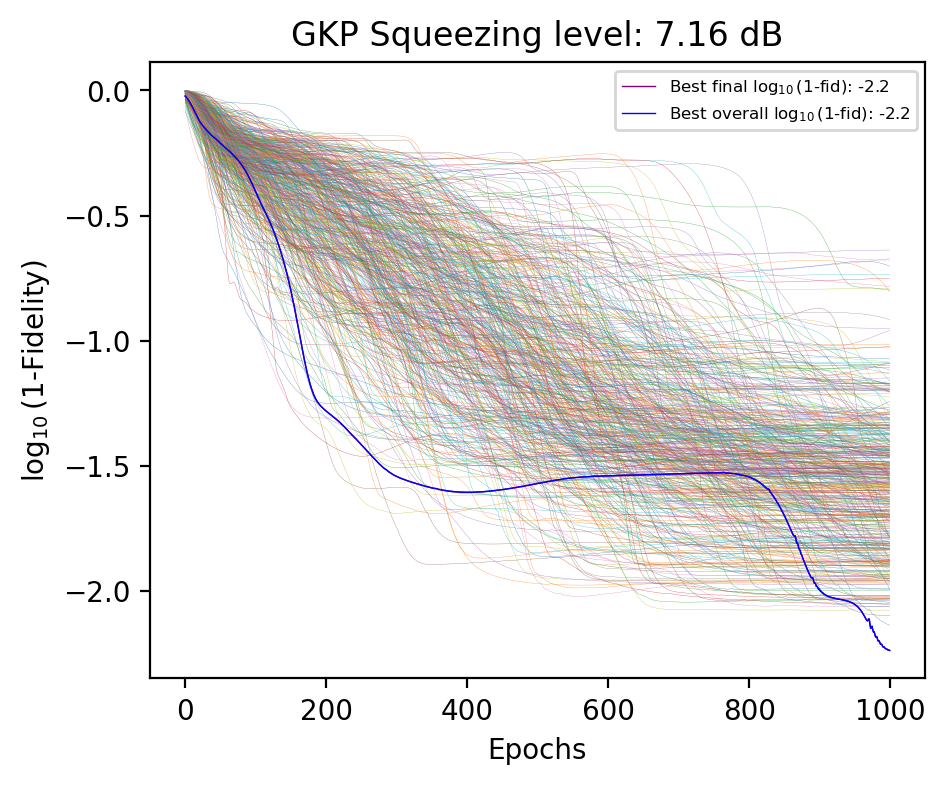

In [13]:
fig, ax = plt.subplots(1,1, dpi=200, figsize=(5,4))
ax.plot(jnp.log10(1-fids_history), linestyle='-', linewidth=0.1)
ax.plot(jnp.log10(1-fids_history[:,best_final_fid_batch_indx]), linestyle='-', linewidth=0.5, color='purple', label="Best final $\log_{10}$(1-fid): " + f"{log_infid_history[-1,best_final_fid_batch_indx]:.2}")
ax.plot(jnp.log10(1-fids_history[:,best_fid_batch_indx]), linestyle='-', linewidth=0.5, color='blue', label="Best overall $\log_{10}$(1-fid): " + f"{log_infid_history[best_fid_epoch_indx,best_fid_batch_indx]:.2}")
ax.set_xlabel("Epochs")
ax.set_ylabel(r"$\log_{10}$(1-Fidelity)")
ax.set_title(title)
# ax.set_title(f"GKP (Δ={gkp_qubit.params['delta']}) State Preparation")
ax.legend(fontsize=6)
print(f"Regularization loss: {regularize(best_params):.3f}")
print(f"Total loss: {metric(jnp.array([best_params]), settings['target_state']):.3f}")

# 5 - Plotting Optimal

### (optionally) Load old params

In [14]:
#data=np.load(r"/home/rolleri/repos/jaxquantum/experiments/circuit/data/20250630_h17m35s31_gkp_state_prep.npz", allow_pickle=True)
#optimal_instructions = data["best_params"]

#best_params = jnp.array([optimal_instructions[0], optimal_instructions[1], optimal_instructions[2], optimal_instructions[3]])

#prepared_state = run_circuit(best_params, 100)

### Plot

In [15]:
def qubit_phase(beta_squared, η0, η2, η4, η6, ξ2, ξ4, offset):
    beta_squared = np.abs(beta_squared)
    theta = ξ2 * beta_squared + ξ4 * beta_squared**2
    sx = np.cos(2*theta)
    sy = np.sin(2*theta)
    purity_scale_factor = (1 - (η0 + η2 *beta_squared + η4 * beta_squared**2 + η6 * beta_squared**3))
    return sx * purity_scale_factor + offset, sy * purity_scale_factor + offset

def purity_func(beta_squared, η0, η2, η4, η6, ξ2, ξ4, offset):
    sx, sy = qubit_phase(beta_squared, η0, η2, η4, η6, ξ2, ξ4, offset)
    return 0.5 * (1 + sx**2 + sy**2)

def calculate_envelope(betas_re, betas_im, fit_vals):
    betas_re_grid, betas_im_grid = jnp.meshgrid(betas_re, betas_im)
    betas_squared_grid = jnp.abs(betas_re_grid)**2 + jnp.abs(betas_im_grid)**2
    purity_vals = purity_func(betas_squared_grid, *fit_vals)
    envelope = 2*(purity_vals-0.5)
    return envelope


fit_vals = (0.39097432835648155,
 0.034291746251959555,
 -0.0010010145791953715,
 1.0867037992914275e-05,
 -0.04611114282106909,
 9.382815933549335e-06,
 0.07836293463518865)

Best parameters: 
 [[ 0.6997    0.41364   0.075049  0.347733  0.141864  0.740268  0.816067]
 [ 0.749151  0.342381  0.085207  0.836043  0.928036  0.947822  0.748806]
 [-1.619372 -0.901525 -0.167361 -0.702379  1.131138  0.054319 -0.117756]
 [-0.105047 -0.512531  1.362054 -0.194143 -0.316677  0.313275  0.002376]]


Text(0.5, 1.02, '20250703_h18m39s25_gkp_state_prep.npz, $\\vert-x\\rangle, \\Delta=0.4385$, $M=None$, $N_B=7$, $\\beta=0.5$')

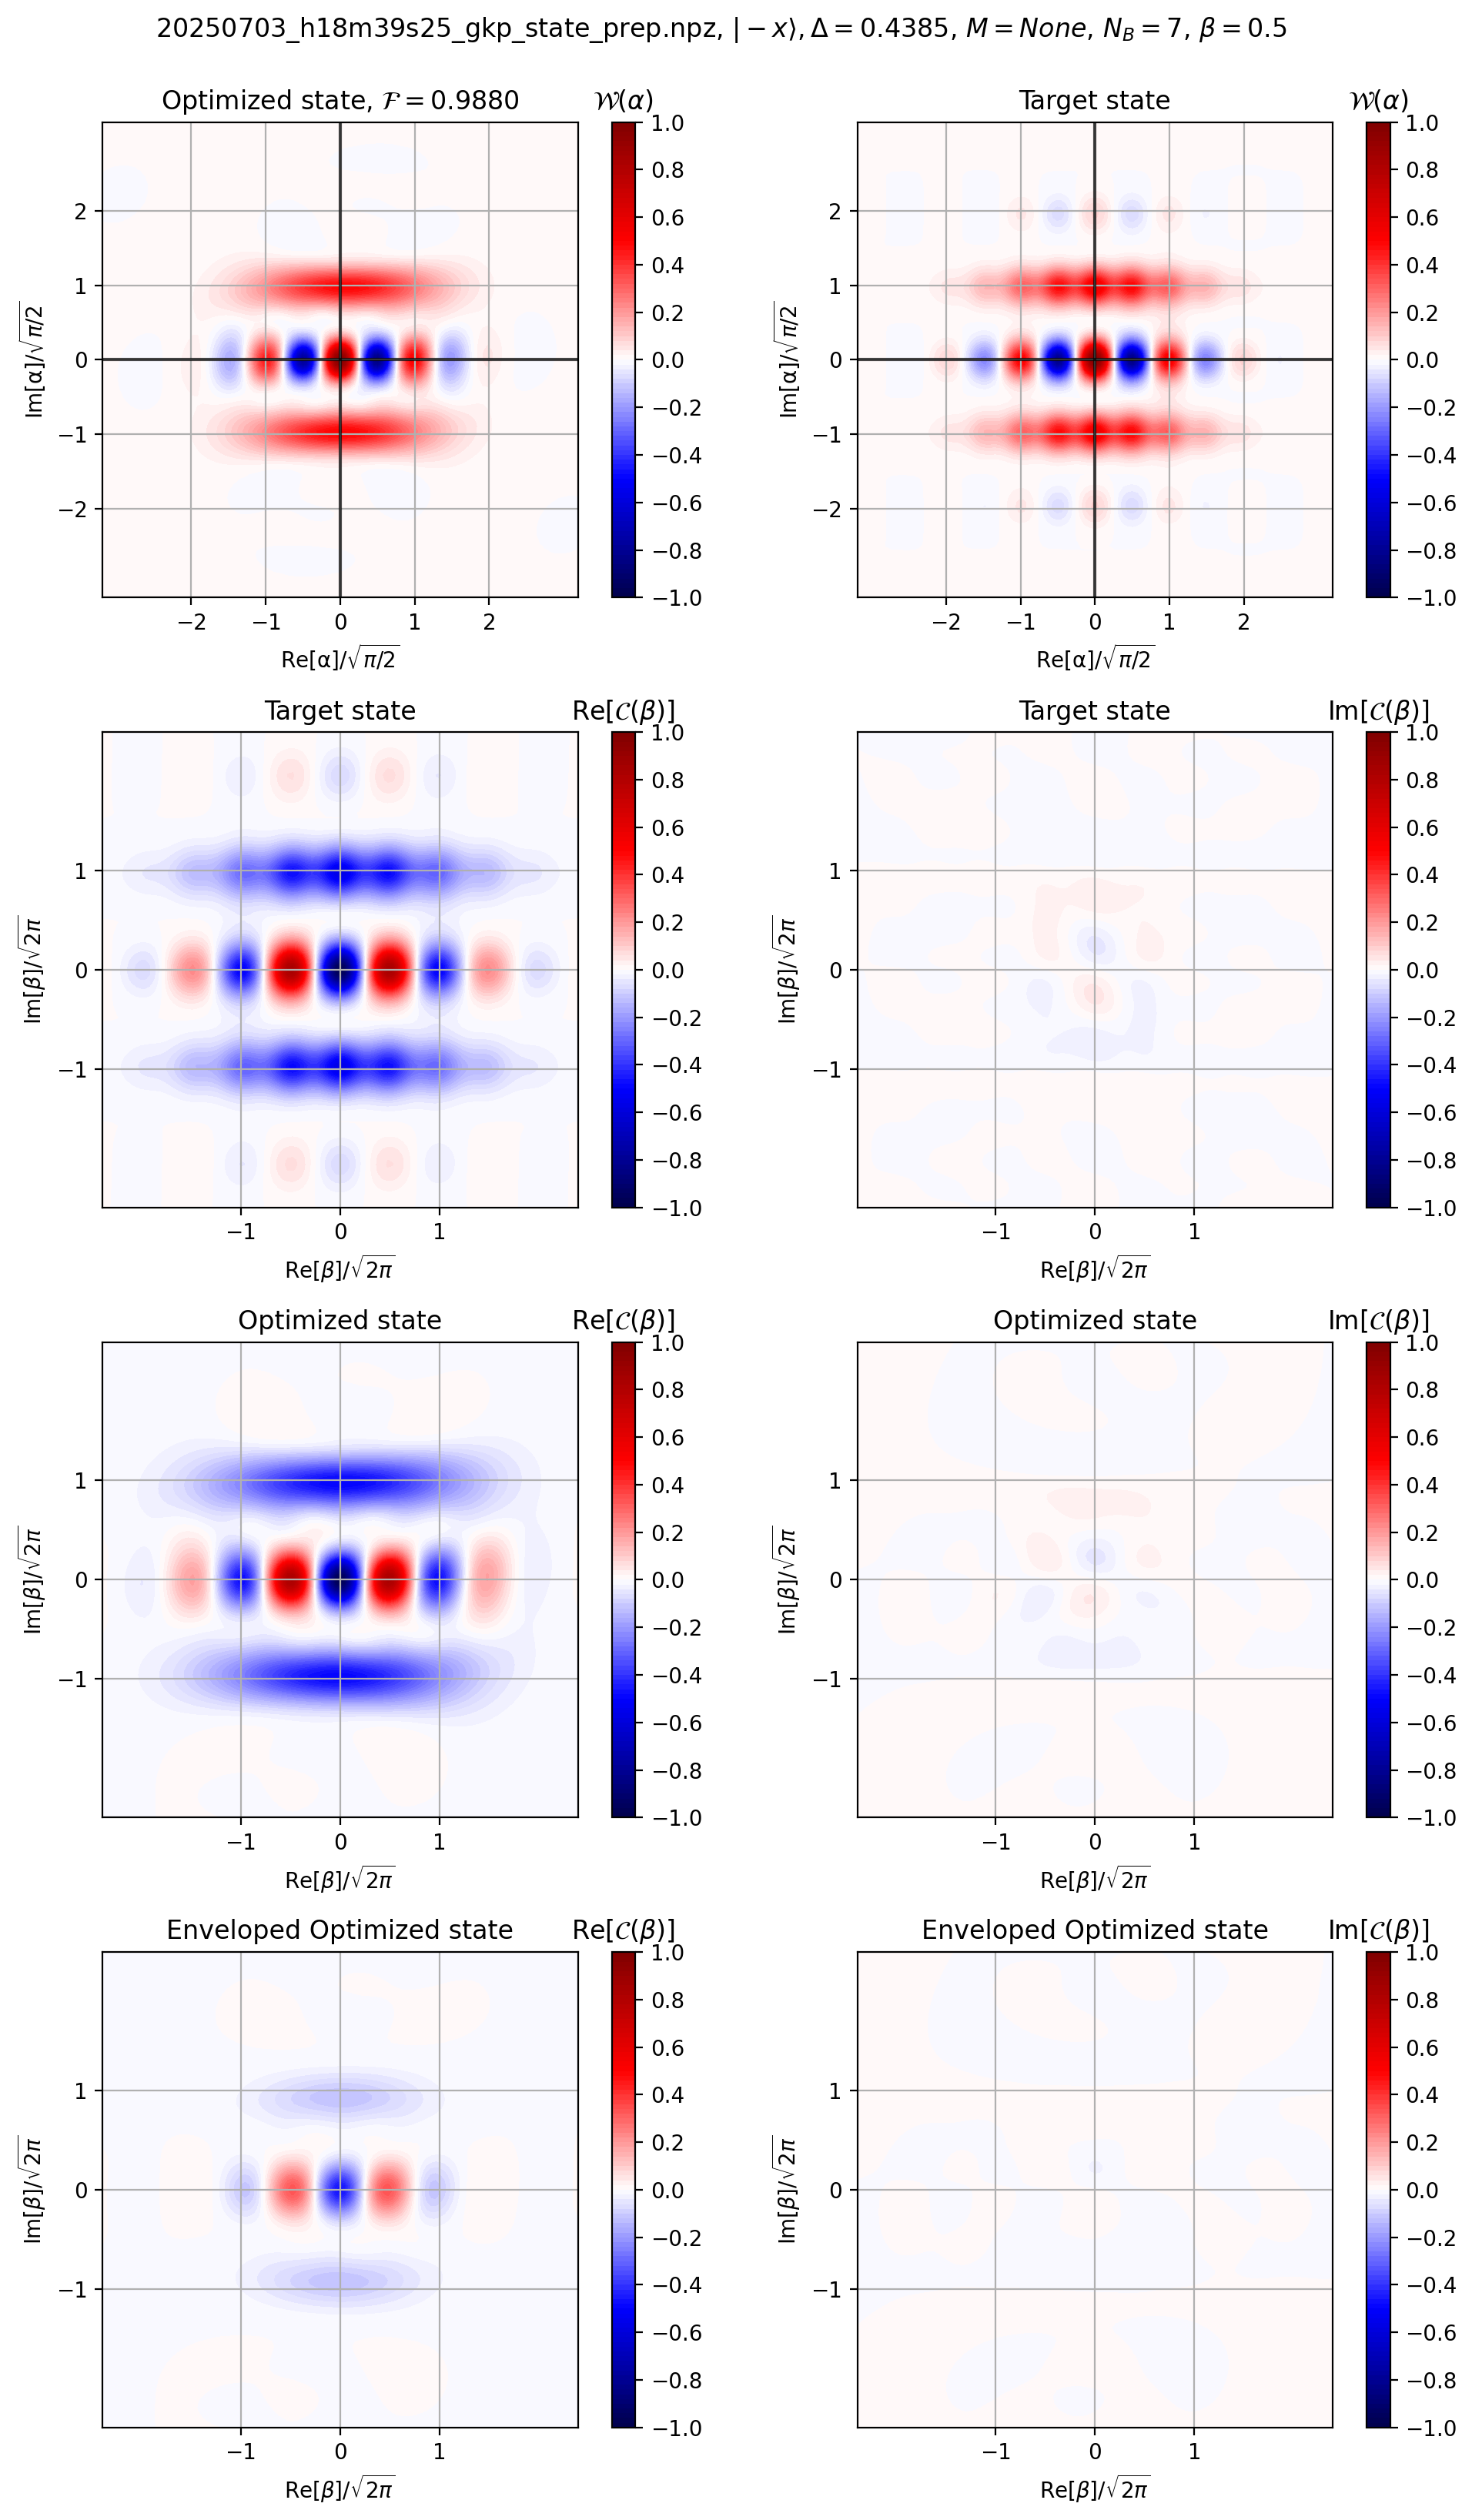

In [16]:
fig, axs = plt.subplots(4,2, dpi=200, figsize=(10,16))
axs = axs.flatten()
print("Best parameters: \n", best_params)

if settings["state"]["mode"] == "gkp":
    N_large = settings["N_large"]
    gkp_qubit_larger = jqtb.GKPQubit({"delta": settings["state"]["delta"], "N": N_large})
    target_state_larger = jqt.basis(2,0) ^ gkp_qubit_larger.basis[settings["state"]["logical_state"]]
 
prepared_state = run_circuit(best_params, N_large)
fid = jnp.real(jqt.overlap(target_state_larger, prepared_state)) 
pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(jqt.ptrace(prepared_state,1), pts, ax=axs[0], axis_scale_factor=1/(jnp.sqrt(np.pi/2)))

ax.set_xticks([-2,-1, 0, 1,2])
ax.set_yticks([-2,-1, 0, 1,2])

ax.set_xlabel(r"Re[α]/$\sqrt{\pi/2}$")
ax.set_ylabel(r"Im[α]/$\sqrt{\pi/2}$")
# ax.set_title("Prepared state\n" + f"(N=50) Fidelity: {best_fid:.5f}\n" + f"(N={N}) Fidelity: {fid:.5f}")
ax.set_title(f"Optimized state, $\mathcal{{F}}={fid:.4f}$")


pts = jnp.linspace(-4,4, 101)
ax, im = jqt.plot_wigner(target_state_larger.ptrace(1), pts, ax=axs[1], axis_scale_factor=1/(jnp.sqrt(np.pi/2)))

ax.set_xticks([-2,-1, 0, 1,2])
ax.set_yticks([-2,-1, 0, 1,2])

ax.set_xlabel(r"Re[α]/$\sqrt{\pi/2}$")
ax.set_ylabel(r"Im[α]/$\sqrt{\pi/2}$")
ax.set_title("Target state")


betas_re = jnp.linspace(-6,6, 101)
betas_im = jnp.linspace(-6,6, 101)

cf_vals, _, _ = sim_cf(settings["target_state"], betas_re, betas_im)

for j, ax in enumerate((axs[2], axs[3])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Target state")

cf_vals, _, _ = sim_cf(prepared_state, betas_re, betas_im)

for j, ax in enumerate((axs[4], axs[5])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Optimized state")

envelope = calculate_envelope(betas_re, betas_im, fit_vals)

final_state = prepared_state
cf_vals, betas_re, betas_im = sim_cf(final_state, betas_re, betas_im)
cf_vals = envelope * cf_vals

for j, ax in enumerate((axs[6], axs[7])):
    vmin=-1
    vmax=1
    sf = 1/(jnp.sqrt(2*jnp.pi))

    if j == 0:
        cf_vals_plot = jnp.real(cf_vals)
        cbar_title = r"Re[$\mathcal{C}(\beta)$]"
    else:
        cf_vals_plot = jnp.imag(cf_vals)
        cbar_title = r"Im[$\mathcal{C}(\beta)$]"

    im = ax.contourf(betas_re*sf, betas_im*sf, cf_vals_plot.T, levels=np.linspace(vmin, vmax, 101), cmap="seismic", vmin=vmin, vmax=vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid()

    ax.set_xticks([-1,0, 1])
    ax.set_yticks([-1,0, 1])
    ax.set_xlabel(r"Re[$\beta$]/$\sqrt{2\pi}$")
    ax.set_ylabel(r"Im[$\beta$]/$\sqrt{2\pi}$")

    cbar = plt.colorbar(im, ax=ax, orientation="vertical")
    cbar.ax.set_title(cbar_title)
    cbar.ax.set_yticks(np.linspace(-1, 1, 11))

    ax.set_title(r"Enveloped Optimized state")

fig.tight_layout()
fig.suptitle(f"{date_str}_{settings['state']['mode']}_state_prep.npz, $\\vert{settings['state']['logical_state']}\\rangle, \\Delta={delta:.4f}$, $M={settings['measure']}$, $N_B={settings['blocks']}$, $\\beta={settings['reg_strength']}$", y=1.02)